In [ ]:
import MySQLdb
con = MySQLdb.connect(host='192.168.0.95', user='team2', password='Encore_team2@', db='team2')
cursor = con.cursor()

In [5]:
import pandas as pd 
import sqlalchemy
from urllib import parse
user = 'team2'
password = 'Encore_team2@'
host='192.168.0.95'
port = 3306
database = 'team2'
password = parse.quote_plus(password)
engine = sqlalchemy.create_engine(f"mysql://{user}:{password}@{host}:{port}/{database}")


In [217]:
# gender_age 테이블에서 원하는 데이터 가져오기 
gender_age = pd.read_sql_query("WITH ym_total AS ( \
        SELECT  \
            year, \
            month, \
            SUM(num) AS num, \
            SUM(num) - LAG(SUM(num)) OVER (ORDER BY year, month) AS diff_num \
        FROM  \
           gender_age \
        GROUP BY  \
           year, month \
        ORDER BY  \
        year, month \
    ), \
    al_diff_numm AS ( \
            SELECT  \
            a.year,  \
            a.month, \
            a.gender, \
            a.age, \
            a.district_si, \
            a.num, \
            (a.num - b.num) AS diff_num \
        FROM  \
            gender_age AS a \
            JOIN gender_age AS b  \
            ON  \
                a.gender = b.gender \
                AND a.age = b.age \
                AND a.district_si = b.district_si \
        		AND ((a.month = 1 AND b.year = a.year - 1 AND b.month = 12) OR (a.month != 1 AND b.year = a.year AND b.month = a.month - 1))\
        ORDER BY  \
            a.year, a.month, a.gender, a.age, a.district_si \
    ) \
    SELECT  \
        a.year \
        , a.month \
        , a.gender \
        , a.age \
        , a.district_si \
        , a.num \
        , a.diff_num \
		, yt.diff_num AS month_total \
        , (a.diff_num / yt.diff_num)*100 AS diff_percent \
    FROM al_diff_numm a \
        JOIN ym_total yt ON yt.year = a.year AND yt.month = a.month "  , con=engine)

In [241]:
gender_age

,year,month,gender,age,district_si,num,diff_num,month_total,diff_percent
0,2023,11,남성,10대이하,서울,2297,-9,36754.0,-0.0245
1,2023,11,남성,20대,서울,53198,-101,36754.0,-0.2748
2,2023,11,남성,30대,서울,317476,-1203,36754.0,-3.2731
3,2023,11,남성,40대,서울,502921,-359,36754.0,-0.9768
4,2023,11,남성,50대,서울,532649,1034,36754.0,2.8133
...,...,...,...,...,...,...,...,...,...
3667,2024,10,여성,50대,제주,34488,-28,19910.0,-0.1406
3668,2024,10,여성,60대,제주,22463,128,19910.0,0.6429
3669,2024,10,여성,70대,제주,5058,80,19910.0,0.4018
3670,2024,10,여성,80대,제주,753,12,19910.0,0.0603


In [ ]:
import pandas as pd

 # NaN 또는 '' , 0일 경우 조건에서 제외
# year = 2024 # 특정년도 또는 0 사용
# month = 8 # 특정월 또는 0 사용 
# gender = '여성'  # 여성/남성/전체(sum)/공백(all)
# age = ''  # 10대이하/20대...80대/90대이상, 전체(sum), 공백(all)
# district_si = '전체'  # 시도 또는 전체(sum), 공백(all)

def draw_table(year, month, gender, age, district_si):
    # 조건에 맞는 데이터 필터링
    # 필수 조건 포함
    filtered_df = gender_age.copy()

    # 선택적 조건 추가
    if pd.notna(year) and year != '' and year != 0:
        filtered_df = filtered_df[filtered_df['year'] == year]
    if pd.notna(month) and month != ''and month != 0:
        filtered_df = filtered_df[filtered_df['month'] == month]
    if pd.notna(gender) and gender != ''and gender != '전체':
        filtered_df = filtered_df[filtered_df['gender'] == gender]
    if pd.notna(age) and age != ''and age != '전체':
        filtered_df = filtered_df[filtered_df['age'] == age]
    if pd.notna(district_si) and district_si != '' and district_si != '전체':
        filtered_df = filtered_df[filtered_df['district_si'] == district_si]

    groupby_columns = ['year', 'month', 'gender', 'age', 'district_si']

    if gender == '전체':
        groupby_columns.remove('gender')
    if age == '전체':
        groupby_columns.remove('age')
    if district_si == '전체':
        groupby_columns.remove('district_si')

    # 그룹화 및 집계 수행 (age를 포함하지 않고 그룹화한 후, 각 age 값에 대해 sum 적용)
    grouped = filtered_df.groupby(groupby_columns, dropna=False).agg({
        'num': 'sum',
        'diff_num': 'sum',
        'diff_percent' : 'sum'
    }).reset_index()

    # 결과 출력
    
grouped_fe = draw_table(0, 0, '여성', '', '전체')
grouped_m = draw_table(0, 0, '남성', '', '전체')

In [374]:
def draw_table(year=0, month=0, gender='', age='', district_si=''):
    # 조건에 맞는 데이터 필터링
    filtered_df = gender_age

    # 선택적 조건 추가
    if pd.notna(year) and year != '' and year != 0:
        filtered_df = filtered_df[filtered_df['year'] == year]
    if pd.notna(month) and month != '' and month != 0:
        filtered_df = filtered_df[filtered_df['month'] == month]
    if pd.notna(gender) and gender != '' and gender != '전체':
        filtered_df = filtered_df[filtered_df['gender'] == gender]
    if pd.notna(age) and age != '' and age != '전체':
        filtered_df = filtered_df[filtered_df['age'] == age]
    if pd.notna(district_si) and district_si != '' and district_si != '전체':
        filtered_df = filtered_df[filtered_df['district_si'] == district_si]

    # 그룹화 컬럼 설정
    groupby_columns = ['year', 'month', 'gender', 'age', 'district_si']
    if gender == '전체':
        groupby_columns.remove('gender')
    if age == '전체':
        groupby_columns.remove('age')
    if district_si == '전체':
        groupby_columns.remove('district_si')

    # 그룹화 및 집계 수행
    grouped = filtered_df.groupby(groupby_columns, dropna=False).agg({
        'num': 'sum',
        'diff_num': 'sum',
        'diff_percent': 'sum'
    }).reset_index()

    # 결과 반환
    return grouped

# 함수 호출 예시
grouped_fe = draw_table(0, 0, '여성', '', '전체')
grouped_m = draw_table(0, 0, '남성', '', '전체')
draw_table(0, 0, '남성', '40대', '전체')


,year,month,gender,age,num,diff_num,diff_percent
0,2023,11,남성,40대,3973767,-1220,-3.3192
1,2023,12,남성,40대,3966695,-7072,-41.3107
2,2024,1,남성,40대,3961467,-5228,-12.9169
3,2024,2,남성,40대,3961451,-16,-0.0547
4,2024,3,남성,40대,3948981,-12470,-39.7032
5,2024,4,남성,40대,3931639,-17342,-127.2060
6,2024,5,남성,40대,3922493,-9146,-47.1274
7,2024,6,남성,40대,3917528,-4965,-18.9960
8,2024,7,남성,40대,3911713,-5815,-23.9684
9,2024,8,남성,40대,3901295,-10418,-98.9176


In [399]:
# 함수화 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def draw_plot(data: pd.DataFrame):
    fe_df = data.copy()

    # 'date' 열 생성 (year와 month를 조합하여 생성)
    fe_df['date'] = fe_df['year'].astype(str) + '-' + fe_df['month'].astype(str).str.zfill(2)

    # 날짜별 총 등록대수 계산
    total_num_per_date = fe_df.groupby('date')['num'].sum()

    # 날짜별 age별 증감률(diff_num) 합계
    diff_percent_sum_per_age = fe_df.groupby(['date', 'age'])['diff_num'].sum().unstack()

    # 그래프 설정
    fig, ax1 = plt.subplots(figsize=(15, 8))

    # 왼쪽 y축: 총 등록대수에 대한 막대 그래프
    ax1.bar(total_num_per_date.index, total_num_per_date, color='lightgrey', label='Total num')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('총등록건수(누적)')
    ax1.set_ylim([total_num_per_date.min() - 100000, total_num_per_date.max() + 100000])  # 최솟값을 0 이상으로 조정

     # 막대 위에 숫자 추가
    for x, total in enumerate(total_num_per_date):
        ax1.text(x, total + 50000, f'{int(total):,}', ha='center', va='bottom', fontsize=10, color='black')
    # 오른쪽 y축: age별 증감률(diff_percent)에 대한 선 그래프
    ax2 = ax1.twinx()
    for i, age in enumerate(diff_percent_sum_per_age.columns):
        ax2.plot(diff_percent_sum_per_age.index, diff_percent_sum_per_age[age], marker='o', label=f'{age}', linestyle='-', alpha=0.8)

    ax2.axhline(0, color='black', linewidth=0.5)  # 0을 기준으로
    ax2.set_ylabel('증감수')
    # ax2.set_ylim([-100, 100])  # diff_percent의 범위 설정

    # 범례 및 그래프 설정
    fig.suptitle('차량등록인원수및 등록/말소 그래프')
    ax1.set_xticks(range(len(total_num_per_date.index)))
    ax1.set_xticklabels(total_num_per_date.index, rotation=45, ha="right")
    ax1.legend(loc='upper left')
    ax2.legend(title='연령대', loc='upper right')

    plt.tight_layout()
    plt.show()


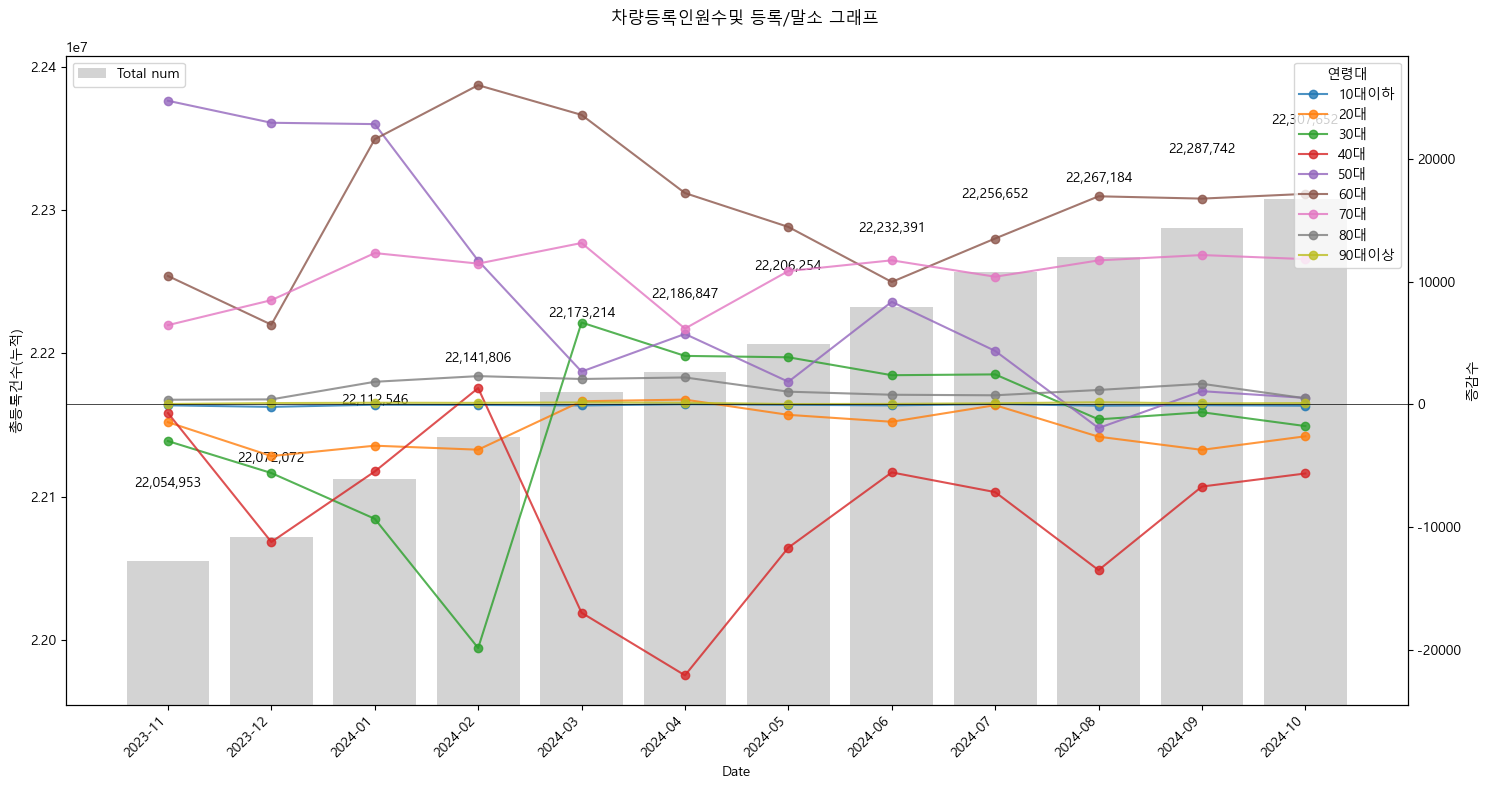

In [ ]:
# 변수에 따른 그래프 보기 (성별, 나잇대만 변경가능 )
change_data = draw_table(0, 0, '', '', '전체')
draw_plot(change_data)


In [ ]:
# 변수에따른 테이블 보기 

draw_table(0, 0, '남성', '40대', '전체')

,year,month,gender,age,num,diff_num,diff_percent
0,2023,11,남성,40대,3973767,-1220,-3.3192
1,2023,12,남성,40대,3966695,-7072,-41.3107
2,2024,1,남성,40대,3961467,-5228,-12.9169
3,2024,2,남성,40대,3961451,-16,-0.0547
4,2024,3,남성,40대,3948981,-12470,-39.7032
5,2024,4,남성,40대,3931639,-17342,-127.2060
6,2024,5,남성,40대,3922493,-9146,-47.1274
7,2024,6,남성,40대,3917528,-4965,-18.9960
8,2024,7,남성,40대,3911713,-5815,-23.9684
9,2024,8,남성,40대,3901295,-10418,-98.9176


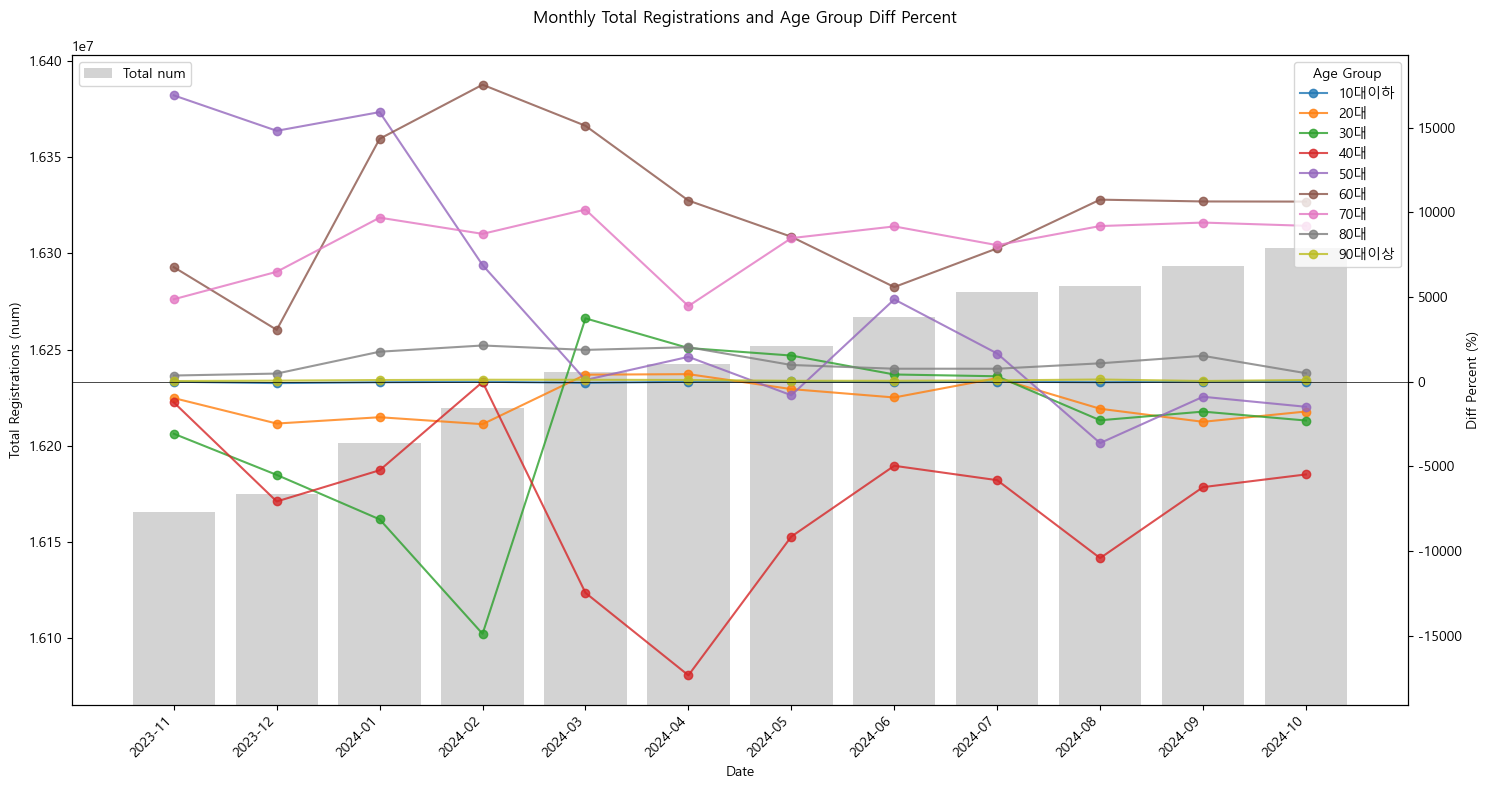

In [ ]:
# 남
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


m_df = grouped_m.copy()

# 'date' 열 생성 (year와 month를 조합하여 생성)
m_df['date'] = m_df['year'].astype(str) + '-' + m_df['month'].astype(str).str.zfill(2)

# 날짜별 총 등록대수 계산
total_num_per_date = m_df.groupby('date')['num'].sum()

# 날짜별 age별 증감률(diff_num) 합계
diff_percent_sum_per_age = m_df.groupby(['date', 'age'])['diff_num'].sum().unstack()

# 그래프 설정
fig, ax1 = plt.subplots(figsize=(15, 8))

# 왼쪽 y축: 총 등록대수에 대한 막대 그래프
ax1.bar(total_num_per_date.index, total_num_per_date, color='lightgrey', label='Total num')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Registrations (num)')
ax1.set_ylim([total_num_per_date.min() - 100000, total_num_per_date.max() + 100000])  # 최솟값을 0 이상으로 조정

# 오른쪽 y축: age별 증감률(diff_percent)에 대한 선 그래프
ax2 = ax1.twinx()
for i, age in enumerate(diff_percent_sum_per_age.columns):
    ax2.plot(diff_percent_sum_per_age.index, diff_percent_sum_per_age[age], marker='o', label=f'{age}', linestyle='-', alpha=0.8)

ax2.axhline(0, color='black', linewidth=0.5)  # 0을 기준으로
ax2.set_ylabel('Diff Percent (%)')
# ax2.set_ylim([-100, 100])  # diff_percent의 범위 설정

# 범례 및 그래프 설정
fig.suptitle('Monthly Total Registrations and Age Group Diff Percent')
ax1.set_xticks(range(len(total_num_per_date.index)))
ax1.set_xticklabels(total_num_per_date.index, rotation=45, ha="right")
ax1.legend(loc='upper left')
ax2.legend(title='Age Group', loc='upper right')

plt.tight_layout()
plt.show()

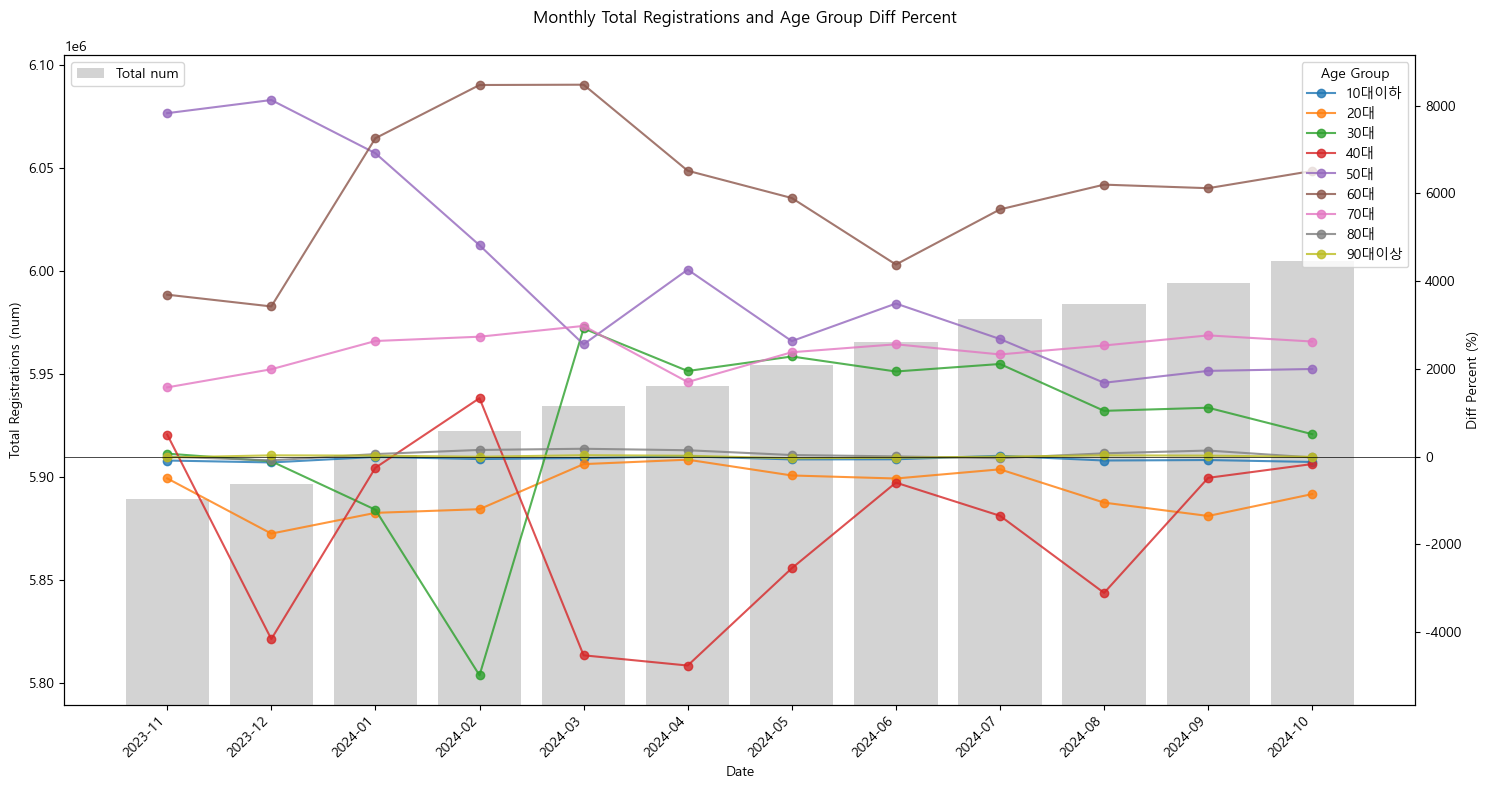

In [ ]:
# 여
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
fe_df = grouped_fe.copy()

# 'date' 열 생성 (year와 month를 조합하여 생성)
fe_df['date'] = fe_df['year'].astype(str) + '-' + fe_df['month'].astype(str).str.zfill(2)

# 날짜별 총 등록대수 계산
total_num_per_date = fe_df.groupby('date')['num'].sum()

# 날짜별 age별 증감률(diff_num) 합계
diff_percent_sum_per_age = fe_df.groupby(['date', 'age'])['diff_num'].sum().unstack()

# 그래프 설정
fig, ax1 = plt.subplots(figsize=(15, 8))

# 왼쪽 y축: 총 등록대수에 대한 막대 그래프
ax1.bar(total_num_per_date.index, total_num_per_date, color='lightgrey', label='Total num')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Registrations (num)')
ax1.set_ylim([total_num_per_date.min() - 100000, total_num_per_date.max() + 100000])  # 최솟값을 0 이상으로 조정

# 오른쪽 y축: age별 증감률(diff_percent)에 대한 선 그래프
ax2 = ax1.twinx()
for i, age in enumerate(diff_percent_sum_per_age.columns):
    ax2.plot(diff_percent_sum_per_age.index, diff_percent_sum_per_age[age], marker='o', label=f'{age}', linestyle='-', alpha=0.8)

ax2.axhline(0, color='black', linewidth=0.5)  # 0을 기준으로
ax2.set_ylabel('Diff Percent (%)')
# ax2.set_ylim([-100, 100])  # diff_percent의 범위 설정

# 범례 및 그래프 설정
fig.suptitle('Monthly Total Registrations and Age Group Diff Percent')
ax1.set_xticks(range(len(total_num_per_date.index)))
ax1.set_xticklabels(total_num_per_date.index, rotation=45, ha="right")
ax1.legend(loc='upper left')
ax2.legend(title='Age Group', loc='upper right')

plt.tight_layout()
plt.show()

In [349]:
m_df

,year,month,gender,age,num,diff_num,diff_percent,date
0,2023,11,남성,10대이하,9741,1,0.0026,2023-11
1,2023,11,남성,20대,540608,-965,-2.6257,2023-11
2,2023,11,남성,30대,2330287,-3072,-8.3583,2023-11
3,2023,11,남성,40대,3973767,-1220,-3.3192,2023-11
4,2023,11,남성,50대,4539376,16916,46.0250,2023-11
...,...,...,...,...,...,...,...,...
103,2024,10,남성,50대,4578332,-1480,-7.4334,2024-10
104,2024,10,남성,60대,3637635,10641,53.4456,2024-10
105,2024,10,남성,70대,1160670,9211,46.2630,2024-10
106,2024,10,남성,80대,182786,504,2.5313,2024-10


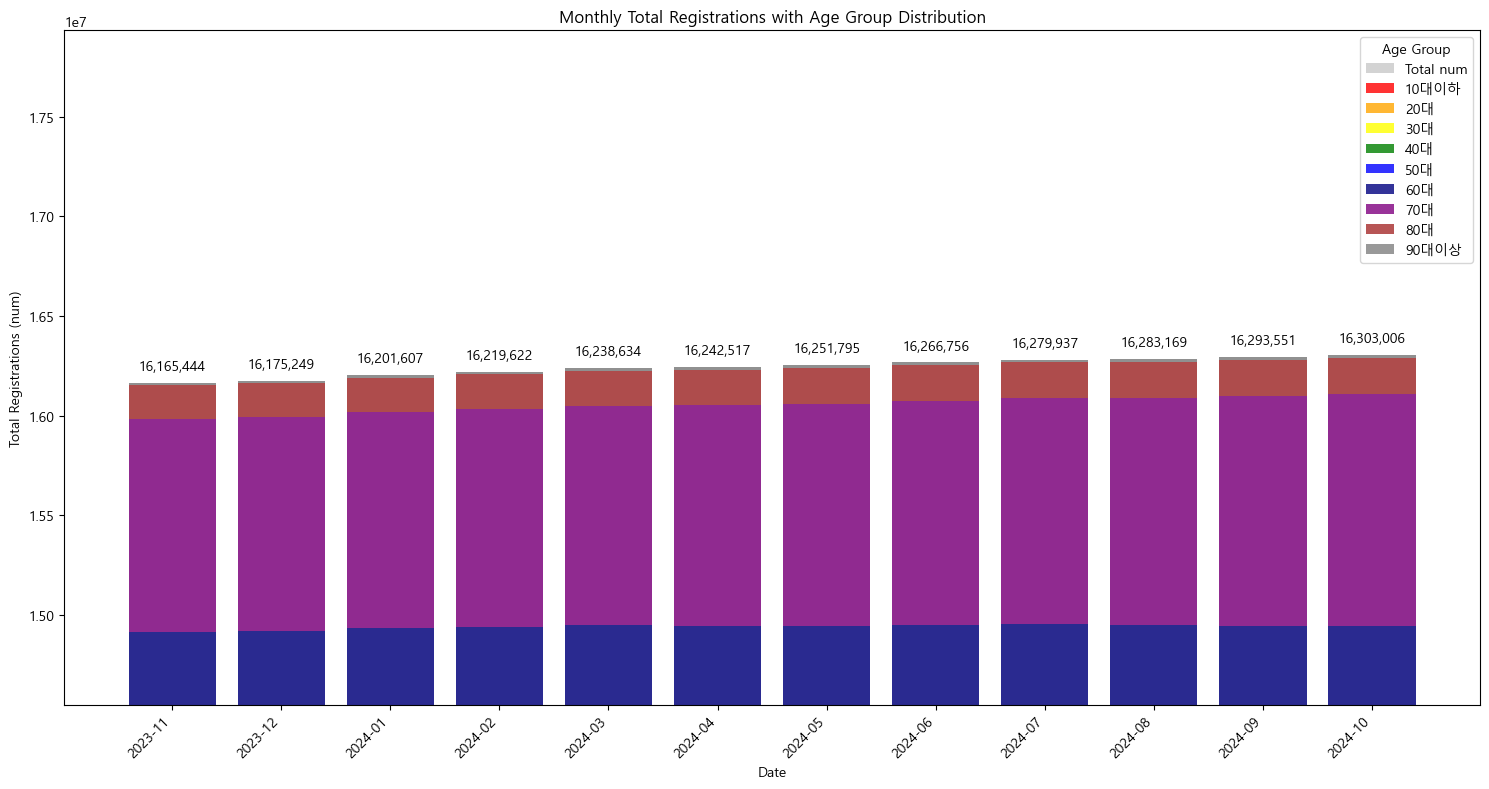

In [368]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 예제 데이터프레임 복사
m_df = grouped_m.copy()


# 'date' 열 생성
m_df['date'] = m_df['year'].astype(str) + '-' + m_df['month'].astype(str).str.zfill(2)

# 날짜별 총 num 합계 계산
total_num_per_date = m_df.groupby('date')['num'].sum()

# 날짜별 age별 num 비율 계산
num_sum_per_age = m_df.groupby(['date', 'age'])['num'].sum().unstack(fill_value=0)

# 색상 팔레트 (나이대에 따른 색상 지정)
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'navy', 'purple', 'brown', 'grey']

# 그래프 설정
fig, ax = plt.subplots(figsize=(15, 8))

# y축 최소 및 최대값 직접 지정
y_min = total_num_per_date.min() * 0.9  # 최소값보다 약간 낮게 설정
y_max = total_num_per_date.max() * 1.1  # 최대값보다 약간 높게 설정
ax.set_ylim([y_min, y_max])

# 각 날짜별 전체 막대를 먼저 그린 후, 가상 색상 구분을 위한 비율 막대 추가
x_values = np.arange(len(total_num_per_date))
ax.bar(x_values, total_num_per_date, color='lightgrey', label='Total num')  # 전체 막대 먼저 그림

# 비율대로 색상 채우기 위한 가상 막대 추가
bottom_stack = np.zeros(len(total_num_per_date))
for i, age in enumerate(num_sum_per_age.columns):
    age_values = num_sum_per_age[age].fillna(0)
    ax.bar(
        x_values, age_values, bottom=bottom_stack, 
        color=colors[i % len(colors)], edgecolor="none", label=f'{age}', alpha=0.8
    )
    bottom_stack += age_values  # 비율 누적 갱신

# 각 막대 꼭대기에 총합 표시
for x, total in zip(x_values, total_num_per_date):
    ax.text(x, total + 50000, f'{int(total):,}', ha='center', va='bottom', fontsize=10, color='black')

# 축 및 제목 설정
ax.set_xlabel('Date')
ax.set_ylabel('Total Registrations (num)')
ax.set_title('Monthly Total Registrations with Age Group Distribution')

# x축 라벨 설정
ax.set_xticks(x_values)
ax.set_xticklabels(total_num_per_date.index, rotation=45, ha="right")

# 범례 및 레이아웃 조정
ax.legend(title='Age Group')
plt.tight_layout()
plt.show()